# Test the decoding function on test data
Here are the main steps in this notebook 
- Generate an artificial data set where we know the ground truth. There will be no difference between the two groups of trials we want to discriminate. 
- Generate data where we create a difference between the two groups of trials.
- Visualize the data for sanity checks
- Apply a linear SVM and test for statistical significance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from numpy.random import default_rng
#instantiate a Generator
rng = default_rng(12345)
#import functions for pseudo-simultaneous neural population
from pseudosimul import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
#each recording session could be taken from a different animal on a different day
n_sessions=10
#generate a list of integers for neuron counts assuming 45-80 neurons are recorded per session
n_neurons=rng.integers(45,80,size=(n_sessions,))
#generate an array with 2 columns. trials of a positive class (e.g. CS+) and trials of a negative class (e.g. CS-)
n_trials=rng.integers(30,60,size=(n_sessions,2))
#normalize all the data to rnage from 0 to 1
scaler=preprocessing.MinMaxScaler()

#assume neural firing rates follow an exponential distribution
#for simplicity, all neurons will have the same average firing rate
firing_rate=3.0
negative_cntrl=[]
positive_cntrl=[]
#generate arrays of trials x neurons
for i in range(n_sessions): # for each session
    X1=rng.exponential(1/firing_rate,size=(n_trials[i,0],n_neurons[i]))
    X2=rng.exponential(1/firing_rate,size=(n_trials[i,1],n_neurons[i]))
    #find the min and max for each neuron for all data together
    scaler.fit(np.concatenate((X1,X2),axis=0))
    #normalize each set of trials
    #append both matrices to the same row of the list
    negative_cntrl.append([scaler.transform(X1),scaler.transform(X2)])
    #increase the firing rates for one of the trial types
    X1_diff=X1+4.0
    #retrain the scaler
    scaler.fit(np.concatenate((X1_diff,X2),axis=0))
    X1_diff=scaler.transform(X1_diff)
    X2=scaler.transform(X2)
    positive_cntrl.append([X1_diff,X2])

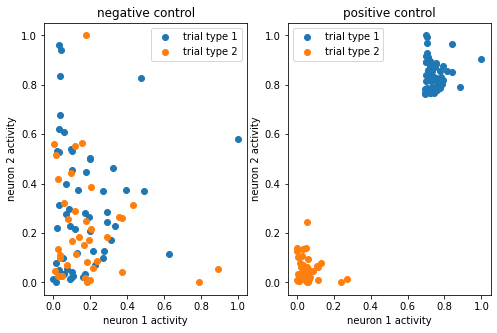

In [3]:
#look at the data for one session
X1=negative_cntrl[0][0]
X2=negative_cntrl[0][1]
#plot the negative control first
fig,ax= plt.subplots(1,2,figsize=(8,5))
#plot the data in neural space using 2 neurons
ax[0].scatter(X1[:,0],X1[:,1], label='trial type 1')
ax[0].scatter(X2[:,0],X2[:,1], label='trial type 2')
ax[0].set_xlabel('neuron 1 activity')
ax[0].set_ylabel('neuron 2 activity')
ax[0].legend()
ax[0].set_title('negative control')
#plot the positive control data
X1=positive_cntrl[0][0]
X2=positive_cntrl[0][1]
ax[1].scatter(X1[:,0],X1[:,1], label='trial type 1')
ax[1].scatter(X2[:,0],X2[:,1], label='trial type 2')
ax[1].set_xlabel('neuron 1 activity')
ax[1].set_ylabel('neuron 2 activity')
ax[1].legend()
ax[1].set_title('positive control')
plt.show()

Each point in the above plots is the normalized neural activity on a given trial. On the left plot, we can see that the activity for this pair of neurons tends to be similar across trials of both types. On the right, this particular pair of neurons responds very low for trial type 2 and very high for trial type 1. The two clouds of points are easily separable in this space. These plots do not tell us about the way activity looks across the whole population of neurons for a particular session.

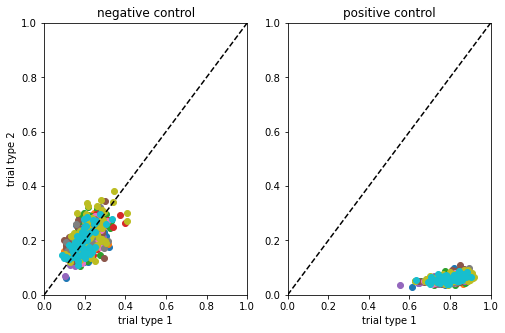

In [4]:
#visualize the data in trial space
domain=[0,1]
fig, ax = plt.subplots(1,2,figsize=(8,5))
for session in negative_cntrl:
    #plot the trial average of each neuron
    ax[0].scatter(session[0].mean(axis=0),session[1].mean(axis=0))
#plot the unity line
ax[0].plot(domain,domain,linestyle = 'dashed',color='black')
ax[0].set_xlabel('trial type 1')
ax[0].set_ylabel('trial type 2')
ax[0].set_ylim(domain)
ax[0].set_xlim(domain)
ax[0].set_title('negative control')
for session in positive_cntrl:
    ax[1].scatter(session[0].mean(axis=0),session[1].mean(axis=0))
ax[1].plot(domain,domain,linestyle = 'dashed', color='black')
ax[1].set_xlabel('trial type 1')
ax[1].set_ylim(domain)
ax[1].set_xlim(domain)
ax[1].set_title('positive control')
plt.show()

Each point in this plot represents the average activity for one neuron. The neurons from each recording session were given the same color, so that each session can be indicated by color. All of the sessions overlap in these plots because we drew all neural activity from the same distribution. On the left, the data is clustered along the unity line which means the activity tends to be the same for both trial types. The graphs give us a good sanity check that the negative control data should not be linearly separable with respect to the trial types. On the right, the data is clustered in a region of high activity for trial type 1 and low activity for trial type 2. This plot tells us that what we saw in the above plot for the example neuron 1 and neuron 2 generalizes to the entire set of neurons from all sessions. Therefore, the positive control data should easily be linearly separable.

In [5]:
n_iter=500
n_trials_train=100
acc, acc_train, acc_shuf=decode(negative_cntrl,n_iter,n_trials_train,training_flag=True,shuffle_flag=True)
acc_pos, acc_train_pos, acc_shuf_pos=decode(positive_cntrl,n_iter,n_trials_train,training_flag=True,shuffle_flag=True)

#create a DataFrame for the accuracies on the shuffled data and training data
accuracy_df=pd.DataFrame({
    'shuffled': acc_shuf,
    'training': acc_train
}, index=np.arange(len(acc_shuf)))
accuracy_df['experiment']='negative control'
temp=pd.DataFrame({
    'shuffled': acc_shuf_pos,
    'training': acc_train_pos
}, index=np.arange(len(acc_shuf_pos)))
temp['experiment']='positive control'
#vertically concatenate the frames
accuracy_df=pd.concat([accuracy_df,temp], sort=False)

#calculate the probability that the held out accuracy is greater than the accuracies of the null distribution
np.mean(acc_shuf_pos>=acc_pos.mean())

0.0

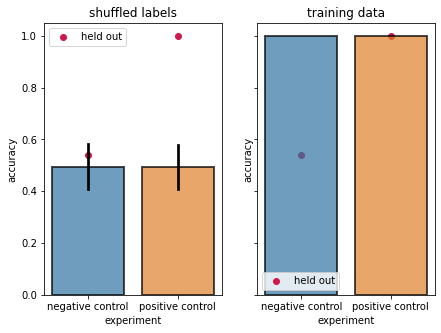

In [6]:
# create a figure with 2 subplots
fig, ax = plt.subplots(1,2,figsize=(7,5),sharey=True)
test_color=[[0.8,0.1,0.3]] #must be 2D array
#plot the std. dev. of each distribution
sns.barplot(data=accuracy_df, x='experiment', y='shuffled', ci='sd', 
           linewidth=2, edgecolor='.0', alpha=0.7, errcolor='.0',ax=ax[0])
#plot the average accuracy of the neural population
ax[0].scatter([0,1],[acc.mean(),acc_pos.mean()], c=test_color,
           label='held out')
ax[0].set_ylabel('accuracy')
ax[0].set_title('shuffled labels')
ax[0].legend()
sns.barplot(data=accuracy_df, x='experiment', y='training', ci='sd', 
           linewidth=2, edgecolor='.0', alpha=0.7, errcolor='.0',ax=ax[1])
ax[1].scatter([0,1], [acc.mean(),acc_pos.mean()], c=test_color,
           label='held out')
ax[1].set_ylabel('accuracy')
ax[1].set_title('training data')
ax[1].legend()
plt.show()

## The control analyses gave the expected results
The data for the negative control results in decoding accuracy that is within one standard deviation of the null distribution produced by simulating the classifer on shuffled data. Also, the positive control data resulted in an accuracy level statistically significant with respect to the null distribution.